# Evaluate Predictions Made on PDX Samples

**Gregory Way, 2018**

In the following notebook I evaluate the predictions made by the Ras and _TP53_ classifiers in the input PDX RNAseq data.

## Procedure

1. Load status matrices
  * These files store the mutation status for _TP53_ and Ras pathway genes for the input samples
2. Align barcode identifiers
  * The identifiers matching the RNAseq data to the status matrix are not aligned.
  * I use an intermediate dictionary to map common identifiers
3. Load predictions (see `1.apply-classifier.ipynb` for more details)
4. Evaluate predictions
  * I visualize the distribution of predictions between wild-type and mutant samples for both classifiers

### Important Caveat

Many of the barcodes require updating.
Some samples are not identified.
I remove these samples from downstream evaluation, but discrepancies should be reconciled at a later date.

## Output

The output of this notebook are several evaluation figures demonstrating the predictive performance on the input data for the two classifiers. Included in this output are predictions stratified by histology.

In [1]:
import os
import random
from decimal import Decimal
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd

from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Load Ras Status Matrix

In [3]:
file = os.path.join('data', 'raw', 'ras.genes.txt')
ras_status_df = pd.read_table(file)

print(ras_status_df.shape)
ras_status_df.head(3)

(73, 20)


,Tumor_Sample_Barcode,Hugo_Symbol,Variant_Type,NCBI_Build,Chromosome,Start_position,End_position,Strand,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Variant_Classification,cDNA_Change,Protein_Change,VAF,Model,Diagnosis,Histology,Sex,Phase
0,COG-N-619x-D1-human,PTPN11,SNP,hg19,12,112926888,112926888,+,G,G,T,Missense_Mutation,c.1508G>T,p.G503V,0.633803,COG-N-619x,Neuroblastoma,Neuroblastoma,Male,Progressing Disease
1,PPTC-AF06-XTP1-A-1-0-D-human,KRAS,SNP,hg19,12,25398284,25398284,+,C,C,A,Missense_Mutation,c.35G>T,p.G12V,0.279503,ALL-108,Ph-likeALL,ALL,Female,Diagnosis
2,PPTC-AF0B-XTP1-A-1-0-D-human,KRAS,SNP,hg19,12,25398266,25398266,+,G,G,T,Missense_Mutation,c.53C>A,p.A18D,0.306220,ALL-118,Ph-likeALL,ALL,Unknown,Unknown


In [4]:
len(ras_status_df.Model.unique())

68

In [5]:
ras_status_df.Hugo_Symbol.value_counts()

ALK       18
KRAS      17
NF1       11
NRAS      10
CIC        7
PTPN11     4
HRAS       3
BRAF       3
Name: Hugo_Symbol, dtype: int64

In [6]:
ras_status_df.Variant_Classification.value_counts()

Missense_Mutation    65
Nonsense_Mutation     5
Frame_Shift_Ins       1
Frame_Shift_Del       1
Splice_Site           1
Name: Variant_Classification, dtype: int64

## Load _TP53_ Status Matrix

In [7]:
file = os.path.join('data', 'raw', 'tp53.muts.txt')
tp53_status_df = pd.read_table(file)
print(tp53_status_df.shape)
tp53_status_df.head(3)

(63, 20)


,Tumor_Sample_Barcode,Hugo_Symbol,Variant_Type,NCBI_Build,Chromosome,Start_position,End_position,Strand,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Variant_Classification,cDNA_Change,Protein_Change,VAF,Model,Diagnosis,Histology,Sex,Phase
0,PPTC-AF08-XTP1-A-1-0-D-human,TP53,SNP,hg19,17,7577543,7577543,+,C,C,T,Missense_Mutation,c.738G>A,p.M246I,0.373134,ALL-115,BCP-ALL,ALL,Male,Relapse
1,PPTC-AF0C-XTP1-B-1-0-D-human,TP53,SNP,hg19,17,7577121,7577121,+,G,G,A,Missense_Mutation,c.817C>T,p.R273C,0.349057,ALL-121,T-ALL,ALL,Female,Relapse
2,PPTC-AF0C-XTP1-B-1-0-D-human,TP53,SNP,hg19,17,7577538,7577538,+,C,C,T,Missense_Mutation,c.743G>A,p.R248Q,0.404255,ALL-121,T-ALL,ALL,Female,Relapse


In [8]:
len(tp53_status_df.Model.unique())

56

In [9]:
tp53_status_df.Hugo_Symbol.value_counts()

TP53    63
Name: Hugo_Symbol, dtype: int64

In [10]:
tp53_status_df.Variant_Classification.value_counts()

Missense_Mutation    45
Nonsense_Mutation     6
Frame_Shift_Del       4
In_Frame_Del          4
Frame_Shift_Ins       2
Splice_Site           2
Name: Variant_Classification, dtype: int64

## Load Clinical Data Information

This stores histology information

In [11]:
file = os.path.join('data', 'raw', '2018-05-22-pdx-clinical.txt')
clinical_df = pd.read_table(file)

# Make every histology with the word `Other` in it in the same class
clinical_df.loc[clinical_df.Histology.str.contains('Other'), 'Histology'] = "Other"

print(clinical_df.shape)
clinical_df.head(3)

(370, 7)


,Part of PPTC,Tumor_Sample_Barcode,Model,Diagnosis,Histology,Sex,Sample Phase of Therapy
0,yes,COG-N-589x-D1-human,COG-N-589x,Neuroblastoma,Neuroblastoma,Female,Diagnosis
1,yes,PPTC-COG-N-590x-D-human,COG-N-590x,Neuroblastoma,Neuroblastoma,Male,Diagnosis
2,yes,PPTC-COG-N-603x-D-human,COG-N-603x,Neuroblastoma,Neuroblastoma,Male,Diagnosis


In [12]:
clinical_df.Histology.value_counts()

ALL                 97
Osteosarcoma        60
Neuroblastoma       45
Medulloblastoma     29
Glioblastoma        22
Rhabdomyosarcoma    20
ATRT                18
Ewing Sarcoma       16
Other               15
Wilms               14
Ependymoma          13
PNET                 9
Astrocytoma          4
DIPG                 4
CNS germinoma        2
AML                  2
Name: Histology, dtype: int64

## Load Predictions

In [13]:
file = os.path.join('results', 'pdx_classifier_scores.tsv')
scores_df = pd.read_table(file)

print(scores_df.shape)
scores_df.head(3)

(275, 5)


,sample_id,ras_score,tp53_score,ras_shuffle,tp53_shuffle
0,ALL-102,0.505979,0.427528,0.568156,0.535022
1,ALL-105,0.406868,0.519200,0.287687,0.427114
2,ALL-106,0.434644,0.361946,0.816345,0.734695


In [14]:
scores_df = scores_df.merge(clinical_df, how='left', left_on='sample_id', right_on='Model')
print(scores_df.shape)
scores_df

(278, 12)


,sample_id,ras_score,tp53_score,ras_shuffle,tp53_shuffle,Part of PPTC,Tumor_Sample_Barcode,Model,Diagnosis,Histology,Sex,Sample Phase of Therapy
0,ALL-102,0.505979,0.427528,0.568156,0.535022,yes,PPTC-AF02-XTP1-B-1-0-D-human,ALL-102,BCP-ALL,ALL,Male,Diagnosis
1,ALL-105,0.406868,0.519200,0.287687,0.427114,yes,PPTC-AF03-XTP1-A-1-0-D-human,ALL-105,BCP-ALL,ALL,Male,Relapse
2,ALL-106,0.434644,0.361946,0.816345,0.734695,yes,PPTC-AF04-XTP1-A-1-0-D-human,ALL-106,Ph-likeALL,ALL,Male,Diagnosis
3,ALL-107,0.368964,0.427656,0.563510,0.609871,yes,PPTC-AF05-XTP1-B-1-0-D-human,ALL-107,Ph-likeALL,ALL,Male,Diagnosis
4,ALL-108,0.436090,0.448713,0.483428,0.682248,yes,PPTC-AF06-XTP1-A-1-0-D-human,ALL-108,Ph-likeALL,ALL,Female,Diagnosis
5,ALL-11,0.388480,0.423440,0.459784,0.632835,yes,NaN,ALL-11,BCP-ALL,ALL,Female,Diagnosis
6,ALL-115,0.442647,0.354012,0.379140,0.792244,yes,PPTC-AF08-XTP1-A-1-0-D-human,ALL-115,BCP-ALL,ALL,Male,Relapse
7,ALL-116,0.643783,0.243333,0.503093,0.374932,yes,PPTC-AF09-XTP1-A-1-0-D-human,ALL-116,Ph-likeALL,ALL,Unknown,Unknown
8,ALL-117,0.357225,0.376697,0.526063,0.526922,yes,PPTC-AF0A-XTP1-A-1-0-D-human,ALL-117,Ph-likeALL,ALL,Unknown,Unknown
9,ALL-118,0.541965,0.270222,0.525847,0.435446,yes,PPTC-AF0B-XTP1-A-1-0-D-human,ALL-118,Ph-likeALL,ALL,Unknown,Unknown


In [15]:
# Did any gene expression values fail to map to barcodes?
scores_df.Model.isna().value_counts()

False    278
Name: Model, dtype: int64

In [16]:
scores_df = (
    scores_df.merge(
        tp53_status_df.loc[:, ['Hugo_Symbol', 'Model']],
        how='left', left_on='Model', right_on='Model'
    )
    .merge(
        ras_status_df.loc[:, ['Hugo_Symbol', 'Model']],
        how='left', left_on='Model', right_on='Model',
        suffixes=('_tp53', '_ras')
    )
)

scores_df.head(2)

,sample_id,ras_score,tp53_score,ras_shuffle,tp53_shuffle,Part of PPTC,Tumor_Sample_Barcode,Model,Diagnosis,Histology,Sex,Sample Phase of Therapy,Hugo_Symbol_tp53,Hugo_Symbol_ras
0,ALL-102,0.505979,0.427528,0.568156,0.535022,yes,PPTC-AF02-XTP1-B-1-0-D-human,ALL-102,BCP-ALL,ALL,Male,Diagnosis,NaN,NaN
1,ALL-105,0.406868,0.519200,0.287687,0.427114,yes,PPTC-AF03-XTP1-A-1-0-D-human,ALL-105,BCP-ALL,ALL,Male,Relapse,NaN,NaN


In [17]:
scores_df = scores_df.assign(tp53_status = scores_df['Hugo_Symbol_tp53'])
scores_df = scores_df.assign(ras_status = scores_df['Hugo_Symbol_ras'])

In [18]:
scores_df.loc[:, ['tp53_status', 'ras_status']] = (
    scores_df.loc[:, ['tp53_status', 'ras_status']].fillna(0)
)

scores_df.loc[:, ['Hugo_Symbol_tp53', 'Hugo_Symbol_ras']] = (
    scores_df.loc[:, ['Hugo_Symbol_tp53', 'Hugo_Symbol_ras']].fillna('wild-type')
)

scores_df.loc[scores_df['tp53_status'] != 0, 'tp53_status'] = 1
scores_df.loc[scores_df['ras_status'] != 0, 'ras_status'] = 1

scores_df.head(2)

,sample_id,ras_score,tp53_score,ras_shuffle,tp53_shuffle,Part of PPTC,Tumor_Sample_Barcode,Model,Diagnosis,Histology,Sex,Sample Phase of Therapy,Hugo_Symbol_tp53,Hugo_Symbol_ras,tp53_status,ras_status
0,ALL-102,0.505979,0.427528,0.568156,0.535022,yes,PPTC-AF02-XTP1-B-1-0-D-human,ALL-102,BCP-ALL,ALL,Male,Diagnosis,wild-type,wild-type,0,0
1,ALL-105,0.406868,0.519200,0.287687,0.427114,yes,PPTC-AF03-XTP1-A-1-0-D-human,ALL-105,BCP-ALL,ALL,Male,Relapse,wild-type,wild-type,0,0


In [19]:
n_classes = 2

fpr_pdx = {}
tpr_pdx = {}
precision_pdx = {}
recall_pdx = {}
auroc_pdx = {}
aupr_pdx = {}

fpr_shuff = {}
tpr_shuff = {}
precision_shuff = {}
recall_shuff = {}
auroc_shuff = {}
aupr_shuff = {}

idx = 0
for status, score, shuff in zip(('ras_status', 'tp53_status'),
                                ('ras_score', 'tp53_score'),
                                ('ras_shuffle', 'tp53_shuffle')):
    
    # Obtain Metrics
    sample_status = scores_df.loc[:, status]
    sample_score = scores_df.loc[:, score]
    shuffle_score = scores_df.loc[:, shuff]
 
    # Get Metrics
    fpr_pdx[idx], tpr_pdx[idx], _ = roc_curve(sample_status, sample_score)
    precision_pdx[idx], recall_pdx[idx], _ = precision_recall_curve(sample_status, sample_score)
    auroc_pdx[idx] = roc_auc_score(sample_status, sample_score)
    aupr_pdx[idx] = average_precision_score(sample_status, sample_score)
    
    # Obtain Shuffled Metrics
    fpr_shuff[idx], tpr_shuff[idx], _ = roc_curve(sample_status, shuffle_score)
    precision_shuff[idx], recall_shuff[idx], _ = precision_recall_curve(sample_status, shuffle_score)
    auroc_shuff[idx] = roc_auc_score(sample_status, shuffle_score)
    aupr_shuff[idx] = average_precision_score(sample_status, shuffle_score)
    
    idx += 1

In [20]:
if not os.path.exists('figures'):
    os.makedirs('figures')

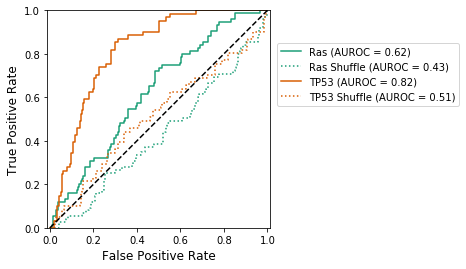

In [21]:
# Visualize ROC curves
plt.subplots(figsize=(4, 4))

labels = ['Ras', 'TP53']
colors = ['#1b9e77', '#d95f02']

for i in range(n_classes):
    plt.plot(fpr_pdx[i], tpr_pdx[i],
             label='{} (AUROC = {})'.format(labels[i], round(auroc_pdx[i], 2)),
             linestyle='solid',
             color=colors[i])

    # Shuffled Data
    plt.plot(fpr_shuff[i], tpr_shuff[i],
             label='{} Shuffle (AUROC = {})'.format(labels[i], round(auroc_shuff[i], 2)),
             linestyle='dotted',
             color=colors[i])

plt.axis('equal')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)

plt.tick_params(labelsize=10)

lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=10)

file = os.path.join('figures', 'pdx_classifier_roc_curve.pdf')
#plt.savefig(file, bbox_extra_artists=(lgd,), bbox_inches='tight')

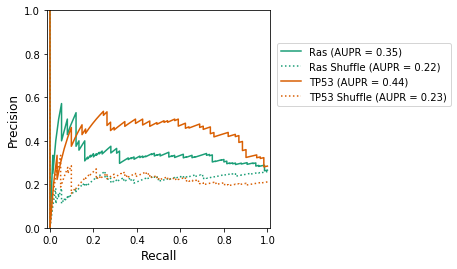

In [22]:
# Visualize PR curves
plt.subplots(figsize=(4, 4))

for i in range(n_classes):
    plt.plot(recall_pdx[i], precision_pdx[i],
             label='{} (AUPR = {})'.format(labels[i], round(aupr_pdx[i], 2)),
             linestyle='solid',
             color=colors[i])
    
    # Shuffled Data
    plt.plot(recall_shuff[i], precision_shuff[i],
             label='{} Shuffle (AUPR = {})'.format(labels[i], round(aupr_shuff[i], 2)),
             linestyle='dotted',
             color=colors[i])

plt.axis('equal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)

plt.tick_params(labelsize=10)

lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=10)

file = os.path.join('figures', 'pdx_classifier_precision_recall_curve.pdf')
#plt.savefig(file, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [23]:
# Output t-test results
t_results_ras = ttest_ind(a = scores_df.query('ras_status == 1').loc[:, 'ras_score'],
                          b = scores_df.query('ras_status == 0').loc[:, 'ras_score'],
                          equal_var = False)
t_results_ras

Ttest_indResult(statistic=3.26080263205946, pvalue=0.0013988066713552195)

In [24]:
# Output t-test results
t_results_tp53 = ttest_ind(a = scores_df.query('tp53_status == 1').loc[:, 'tp53_score'],
                          b = scores_df.query('tp53_status == 0').loc[:, 'tp53_score'],
                          equal_var = False)
t_results_tp53

Ttest_indResult(statistic=10.116957804274891, pvalue=2.6699053137537166e-18)

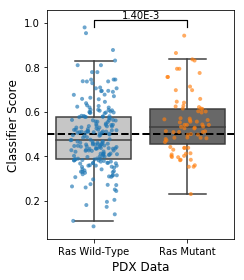

In [25]:
x1, x2 = 0, 1
x3, x4 = -0.2, 0.2
y1, y2, h = 0.98, 1, 0.03

plt.rcParams['figure.figsize']=(3.5, 4)
ax = sns.boxplot(x="ras_status",
                 y="ras_score",
                 data=scores_df,
                 palette = 'Greys',
                 fliersize=0)

ax = sns.stripplot(x="ras_status",
                   y="ras_score",
                   data=scores_df,
                   dodge=True,
                   edgecolor='black',
                   jitter=0.25,
                   size=4,
                   alpha=0.65)

ax.set_ylabel('Classifier Score', fontsize=12)
ax.set_xlabel('PDX Data', fontsize=12)
ax.set_xticklabels(['Ras Wild-Type', 'Ras Mutant'])

# Add Ras T-Test Results
plt.plot([x1, x1, x2, x2], [y1, y1+h, y1+h, y1], lw=1.2, c='black')
plt.text(.5, y1+h, "{:.2E}".format(Decimal(t_results_ras.pvalue)),
         ha='center', va='bottom', color="black")
plt.axhline(linewidth=2, y=0.5, color='black', linestyle='dashed')
plt.tight_layout()


file = os.path.join('figures', 'ras_predictions.pdf')
plt.savefig(file)

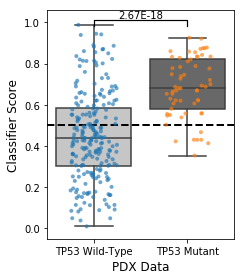

In [26]:
x1, x2 = 0, 1
x3, x4 = -0.2, 0.2
y1, y2, h = 0.98, 1, 0.03

plt.rcParams['figure.figsize']=(3.5, 4)
ax = sns.boxplot(x="tp53_status",
                 y="tp53_score",
                 data=scores_df,
                 palette = 'Greys',
                 fliersize=0)

ax = sns.stripplot(x="tp53_status",
                   y="tp53_score",
                   data=scores_df,
                   dodge=True,
                   edgecolor='black',
                   jitter=0.25,
                   size=4,
                   alpha=0.65)

ax.set_ylabel('Classifier Score', fontsize=12)
ax.set_xlabel('PDX Data', fontsize=12)
ax.set_xticklabels(['TP53 Wild-Type', 'TP53 Mutant'])

# Add Ras T-Test Results
plt.plot([x1, x1, x2, x2], [y1, y1+h, y1+h, y1], lw=1.2, c='black')
plt.text(.5, y1+h, "{:.2E}".format(Decimal(t_results_tp53.pvalue)),
         ha='center', va='bottom', color="black")
plt.axhline(linewidth=2, y=0.5, color='black', linestyle='dashed');
plt.tight_layout()

file = os.path.join('figures', 'tp53_predictions.pdf')
plt.savefig(file)

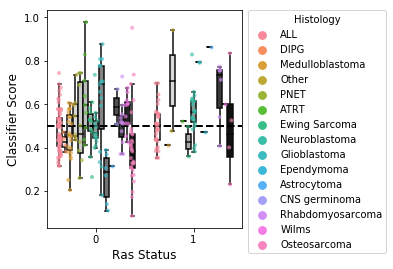

In [27]:
ax = sns.boxplot(x="ras_status",
                 y="ras_score",
                 data=scores_df,
                 hue='Histology',
                 palette = 'Greys',
                 fliersize=0)

ax = sns.stripplot(x="ras_status",
                   y="ras_score",
                   data=scores_df,
                   hue='Histology', 
                   dodge=True,
                   edgecolor='black',
                   jitter=0.25,
                   size=4,
                   alpha=0.65)

ax.set_ylabel('Classifier Score', fontsize=12)
ax.set_xlabel('Ras Status', fontsize=12)
plt.axhline(linewidth=2, y=0.5, color='black', linestyle='dashed')

handles, labels = ax.get_legend_handles_labels()
lgd = plt.legend(handles[15:31], labels[15:31],
               bbox_to_anchor=(1.03, 1),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=10)

lgd.set_title("Histology")

file = os.path.join('figures', 'ras_predictions_histology.pdf')
plt.savefig(file, bbox_extra_artists=(lgd,), bbox_inches='tight')

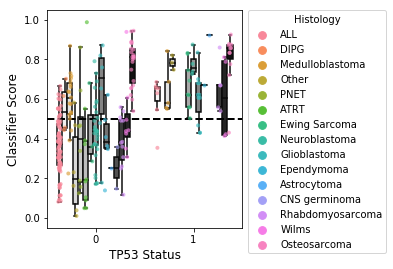

In [28]:
ax = sns.boxplot(x="tp53_status",
                 y="tp53_score",
                 data=scores_df,
                 hue='Histology',
                 palette = 'Greys',
                 fliersize=0)

ax = sns.stripplot(x="tp53_status",
                   y="tp53_score",
                   data=scores_df,
                   hue='Histology', 
                   dodge=True,
                   edgecolor='black',
                   jitter=0.25,
                   size=4,
                   alpha=0.65)

ax.set_ylabel('Classifier Score', fontsize=12)
ax.set_xlabel('TP53 Status', fontsize=12)
plt.axhline(linewidth=2, y=0.5, color='black', linestyle='dashed')

handles, labels = ax.get_legend_handles_labels()
lgd = plt.legend(handles[15:31], labels[15:31],
               bbox_to_anchor=(1.03, 1),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=10)

lgd.set_title("Histology")

file = os.path.join('figures', 'tp53_predictions_histology.pdf')
plt.savefig(file, bbox_extra_artists=(lgd,), bbox_inches='tight')